In [7]:
from collections import Counter
from scipy.special import softmax
from torch_geometric.transforms import ToUndirected
from torch.optim.lr_scheduler import ExponentialLR
from torch_geometric.utils import add_self_loops
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch.nn import BatchNorm1d
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import torch
from sklearn.preprocessing import MinMaxScaler
import uproot
import numpy as np
import h5py
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.preprocessing import label_binarize
import pandas as pd
import awkward as ak
import random
random.seed(42)

## Preparing the Data Dictionary

In [8]:
file = uproot.open('/home/mxg1065/MyxAODAnalysis_super3D.outputs.root')
print(file.keys())

['analysis;1']


In [9]:
tree = file['analysis;1']
branches = tree.arrays()
print(tree.keys()) # Variables per event

['RunNumber', 'EventNumber', 'cell_eta', 'cell_phi', 'cell_x', 'cell_y', 'cell_z', 'cell_subCalo', 'cell_sampling', 'cell_size', 'cell_hashID', 'neighbor', 'seedCell_id', 'cell_e', 'cell_noiseSigma', 'cell_SNR', 'cell_time', 'cell_weight', 'cell_truth', 'cell_truth_indices', 'cell_shared_indices', 'cell_cluster_index', 'cluster_to_cell_indices', 'cluster_to_cell_weights', 'cell_to_cluster_e', 'cell_to_cluster_eta', 'cell_to_cluster_phi', 'cluster_eta', 'cluster_phi', 'cluster_e', 'cellsNo_cluster', 'clustersNo_event', 'jetEnergyWtdTimeAve', 'jetEta', 'jetPhi', 'jetE', 'jetPt', 'jetNumberPerEvent', 'cellIndices_per_jet']


In [10]:
# 100 events and 187652 cells
# Arrays containing information about the energy, noise, and snr for each cell
cell_e = np.array(branches['cell_e'])
cell_noise = np.array(branches['cell_noiseSigma'])
cell_snr = np.array(branches['cell_SNR'])

# Represents the index of the cluster that each cell corresponds to. If the index
# is 0, that means that the given cell does not belong to a cluster.
cell_to_cluster_index = np.array(branches['cell_cluster_index'])

# For each entry, contains the IDs of cells neighboring a given cell
neighbor = branches['neighbor']

num_of_events = len(cell_e) # 100 events

In [11]:
# We use the data arrays to crete a data dictionary, where each entry corresponds
# to the data of a given event; we scale this data.
data = {}

for i in range(num_of_events):
    data[f'data_{i}'] = np.concatenate((np.expand_dims(cell_snr[i], axis=1),
                                        np.expand_dims(cell_e[i], axis=1),
                                        np.expand_dims(cell_noise[i], axis=1)), axis=1)
    
# We combine the data into one array and apply the MinMaxScaler
combined_data = np.vstack([data[key] for key in data])
scaler = MinMaxScaler()
scaled_combined_data = scaler.fit_transform(combined_data)

# The scaled data is split to have the save structure as the original data dict
scaled_data = {}
start_idx = 0
for i in range(num_of_events):
    end_idx = start_idx + data[f"data_{i}"].shape[0]
    scaled_data[f"data_{i}"] = scaled_combined_data[start_idx:end_idx]
    start_idx = end_idx

print(scaled_data["data_0"])
print(scaled_data["data_0"].shape)

[[0.02640459 0.24943821 0.09700817]
 [0.02567646 0.24627675 0.09700815]
 [0.02508186 0.24369499 0.09700817]
 ...
 [0.02632877 0.24791998 0.03177016]
 [0.02705116 0.2511391  0.07512318]
 [0.02638626 0.24820389 0.04149057]]
(187652, 3)


## Preparing Neighbor Pairs

In [12]:
# The IDs of the broken cells (those with zero noise) are collected
broken_cells = []

for i in range(num_of_events):
    cells = np.argwhere(cell_noise[i]==0)
    broken_cells = np.squeeze(cells)

print(broken_cells)

[186986 187352]


In [13]:
# Since the values associated with neighbor[0] and neighbor[1] are all equal
# we will just work with neighbor[0] to simplify our calculations
neighbor = neighbor[0]

In [14]:
len(neighbor)

187652

In [15]:
# We loop through the neighbor awkward array and remove the IDs associated
# with the broken cells
neighbor_pairs_list = []
num_of_cells = len(neighbor) # 187652 cells

for i in range(num_of_cells):
    if i in broken_cells:
        continue
    for j in neighbor[i]:
        if j in broken_cells:
            continue
        neighbor_pairs_list.append((i, int(j)))
# Loops through all cells in the neighbor list. If the loop reaches the cell numbers
# 186986 or 187352, loop skips over these inoperative cells. The final list contains
# tuples (i,j) where i is the cell ID in question and the js are the neighboring cell IDs

In [16]:
# # This code checks to see if the broken cells were removed
# found_broken_cells = []

# for pair in neighbor_pairs_list:
#     # Loop through each cell in pair
#     for cell in pair:
#         # If the cell is broken, appends to list
#         if cell in broken_cells:
#             found_broken_cells.append(cell)

# if found_broken_cells:
#     print("Error: Broken cells are still present in neighbor pairs.")
# else:
#     print("Successfully excluded broken cells.")

In [17]:
# These functions remove permutation variants
def canonical_form(t):
    return tuple(sorted(t))

def remove_permutation_variants(tuple_list):
    unique_tuples = set(canonical_form(t) for t in tuple_list)
    return [tuple(sorted(t)) for t in unique_tuples]

neighbor_pairs_list = np.array(remove_permutation_variants(neighbor_pairs_list))
print(neighbor_pairs_list)
print(neighbor_pairs_list.shape)

[[ 90345 119588]
 [  4388  17680]
 [ 39760  39825]
 ...
 [159757 168717]
 [ 62911  78974]
 [135353 135609]]
(1250242, 2)


## Creating Labels for the Neighbor Pairs

For a given pair of cells and the IDs of the clusters that they belong to (i, j), if
1. i=j and both are nonzero, then both cells are part of the same cluster. 
    * We call these True-True pairs and label them with 1
2. i=j and both are zero, then both cells are not part of any cluster. 
    * We call these Lone-Lone pairs and label them with 0
3. i is nonzero and j=0, then cell i is part of a cluster while cell j is not. 
    * We call these Cluster-Lone pairs and label them with 2
4. i=0 and j is nonzero, then cell i is not part of a cluste while cell j is. 
    * We call these Lone-Cluster pairs and label them with 3
5. i is not the same as j and both are nonzero, then both cells are part of different clusters. 
    * We call these Cluster-Cluster pairs and label them with 4

In [18]:
labels_for_neighbor_pairs = []
for i in range(num_of_events):
    labels_for_neighbor_pairs_for_event_i = []
    for pair in neighbor_pairs_list:
        if cell_to_cluster_index[i][pair[0]] == cell_to_cluster_index[i][pair[1]]:
            if cell_to_cluster_index[i][pair[0]] != 0:
                labels_for_neighbor_pairs_for_event_i.append(1) # True-True
            else:
                labels_for_neighbor_pairs_for_event_i.append(0) # Lone-Lone
        else:
            if cell_to_cluster_index[i][pair[0]] != 0 and cell_to_cluster_index[i][pair[1]] != 0:
                labels_for_neighbor_pairs_for_event_i.append(4) # Cluster-Cluster
            elif cell_to_cluster_index[i][pair[0]] == 0 and cell_to_cluster_index[i][pair[1]] != 0:
                labels_for_neighbor_pairs_for_event_i.append(3) # Lone-Cluster
            else:
                labels_for_neighbor_pairs_for_event_i.append(2) # Cluster-Lone
    labels_for_neighbor_pairs.append(labels_for_neighbor_pairs_for_event_i)

labels_for_neighbor_pairs = np.array(labels_for_neighbor_pairs)
print(labels_for_neighbor_pairs.shape)
print(labels_for_neighbor_pairs)
print(np.unique(labels_for_neighbor_pairs[0]))

(100, 1250242)
[[0 0 0 ... 0 0 2]
 [3 3 0 ... 0 0 2]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 2 0 0]]
[0 1 2 3 4]


## Creating plots for the features

In [19]:
# Here we create a dictionary to store features by class
features_by_class = {cls: {'SNR': [], 'Energy': [], 'Noise': []}
                     for cls in range(5)}

# The features for all events are computed
for i in range(num_of_events):  # Iterate through events
    for pair_idx, pair in enumerate(neighbor_pairs_list):
        class_label = labels_for_neighbor_pairs[i][pair_idx]

        # Vectorized feature extraction for cell pairs
        cell_1_features = [cell_snr[i][pair[0]], cell_e[i][pair[0]], cell_noise[i][pair[0]]]
        cell_2_features = [cell_snr[i][pair[1]], cell_e[i][pair[1]], cell_noise[i][pair[1]]]

        # Append features to the corresponding class
        features_by_class[class_label]['SNR'] += [cell_1_features[0],cell_2_features[0]]
        features_by_class[class_label]['Energy'] += [cell_1_features[1], cell_2_features[1]]
        features_by_class[class_label]['Noise'] += [cell_1_features[2],cell_2_features[2]]

KeyboardInterrupt: 

In [ ]:
# We create a function to precompute bin edges for all features
def precompute_bins(features_by_class, snr_xlim=None, energy_xlim=None, noise_xlim=None, bins=50):
    bins_dict = {}

    # Compute bins for SNR
    if snr_xlim:
        bins_dict['SNR'] = np.linspace(snr_xlim[0], snr_xlim[1], bins + 1)
    else:
        all_snr = np.concatenate([features['SNR']for features in features_by_class.values()])
        bins_dict['SNR'] = np.histogram_bin_edges(all_snr, bins=bins)

    # Compute bins for Energy
    if energy_xlim:
        bins_dict['Energy'] = np.linspace(energy_xlim[0], energy_xlim[1], bins + 1)
    else:
        all_energy = np.concatenate([features['Energy']for features in features_by_class.values()])
        bins_dict['Energy'] = np.histogram_bin_edges(all_energy, bins=bins)

    # Compute bins for Noise
    if noise_xlim:
        bins_dict['Noise'] = np.linspace(noise_xlim[0], noise_xlim[1], bins + 1)
    else:
        all_noise = np.concatenate([features['Noise']for features in features_by_class.values()])
        bins_dict['Noise'] = np.histogram_bin_edges(all_noise, bins=bins)

    return bins_dict


# Optimized function to plot histograms using precomputed bins
def plot_histograms_optimized(features_by_class, bins_dict):
    for class_label, features in features_by_class.items():
        if len(features['SNR']) > 0:  # Ensure there are features to plot
            plt.figure(figsize=(15, 5))

            # Plot SNR histogram with precomputed bins
            plt.subplot(1, 3, 1)
            plt.hist(features['SNR'], bins=bins_dict['SNR'],
                     alpha=0.6, label=f'Class {class_label}')
            plt.xlabel('SNR')
            plt.ylabel('Frequency')
            plt.title(f'Class {class_label}: SNR')
            plt.grid(True)

            # Plot Energy histogram with precomputed bins
            plt.subplot(1, 3, 2)
            plt.hist(features['Energy'], bins=bins_dict['Energy'],
                     alpha=0.6, label=f'Class {class_label}')
            plt.xlabel('Energy')
            plt.ylabel('Frequency')
            plt.title(f'Class {class_label}: Energy')
            plt.grid(True)

            # Plot Noise histogram with precomputed bins
            plt.subplot(1, 3, 3)
            plt.hist(features['Noise'], bins=bins_dict['Noise'],
                     alpha=0.6, label=f'Class {class_label}')
            plt.xlabel('Noise')
            plt.ylabel('Frequency')
            plt.title(f'Class {class_label}: Noise')
            plt.grid(True)

            plt.tight_layout()
            plt.suptitle(
                f'Feature Distributions for Class {class_label}', fontsize=16)
            plt.subplots_adjust(top=0.85)  # Adjust title to prevent overlap
            plt.show()


# Precompute bins for SNR, Energy, and Noise
bins_dict = precompute_bins(features_by_class, snr_xlim=(-6.5, 6.5),
                            energy_xlim=(-500, 500), noise_xlim=(0, 500))

# Call the optimized function to plot histograms
plot_histograms_optimized(features_by_class, bins_dict)

## Preparing the Data for Multi-Class Classification

In [14]:
# Here we collect the indices of the neighbor pairs by the pair type
indices_for_tt_pairs = []  # Label 1
indices_for_ll_pairs = []  # Label 0
indices_for_cl_pairs = []  # Label 2
indices_for_lc_pairs = []  # Label 3
indices_for_cc_pairs = []  # Label 4

for i in range(num_of_events):
    indices_for_tt_pairs.append(list(np.where(labels_for_neighbor_pairs[i] == 1)[0]))
    indices_for_ll_pairs.append(list(np.where(labels_for_neighbor_pairs[i] == 0)[0]))
    indices_for_cl_pairs.append(list(np.where(labels_for_neighbor_pairs[i] == 2)[0]))
    indices_for_lc_pairs.append(list(np.where(labels_for_neighbor_pairs[i] == 3)[0]))
    indices_for_cc_pairs.append(list(np.where(labels_for_neighbor_pairs[i] == 4)[0]))

In [15]:
# Here we collect the number of each pair type across the events
number_of_tt_pairs = [len(indices_for_tt_pairs[i])for i in range(num_of_events)]
number_of_ll_pairs = [len(indices_for_ll_pairs[i])for i in range(num_of_events)]
number_of_cl_pairs = [len(indices_for_cl_pairs[i])for i in range(num_of_events)]
number_of_lc_pairs = [len(indices_for_lc_pairs[i])for i in range(num_of_events)]
number_of_cc_pairs = [len(indices_for_cc_pairs[i])for i in range(num_of_events)]

In [16]:
# Here we perform a 70-30 split on the indices of neighbor pairs
training_indices_tt = indices_for_tt_pairs[:70]
training_indices_ll = indices_for_ll_pairs[:70]
training_indices_cl = indices_for_cl_pairs[:70]
training_indices_lc = indices_for_lc_pairs[:70]
training_indices_cc = indices_for_cc_pairs[:70]

testing_indices_tt = indices_for_tt_pairs[70:]
testing_indices_ll = indices_for_ll_pairs[70:]
testing_indices_cl = indices_for_cl_pairs[70:]
testing_indices_lc = indices_for_lc_pairs[70:]
testing_indices_cc = indices_for_cc_pairs[70:]

# Here we perform a 70-30 split on the number of neighbor pairs
training_num_tt = number_of_tt_pairs[:70]
training_num_ll = number_of_ll_pairs[:70]
training_num_cl = number_of_cl_pairs[:70]
training_num_lc = number_of_lc_pairs[:70]
training_num_cc = number_of_cc_pairs[:70]

testing_num_tt = number_of_tt_pairs[70:]
testing_num_ll = number_of_ll_pairs[70:]
testing_num_cl = number_of_cl_pairs[70:]
testing_num_lc = number_of_lc_pairs[70:]
testing_num_cc = number_of_cc_pairs[70:]

In [17]:
# We check the minimum number of each pair type across the events. When we
# randomly sample from the indices, if our sample is greater than the minimum
# numbers, then we will run into errors
print("Minimum number of pairs for training:")
print("True-True", min(training_num_tt))
print("Lone-Lone", min(training_num_ll))
print("Cluster-Lone", min(training_num_cl))
print("Lone-Cluster", min(training_num_lc))
print("Cluster-Cluster", min(training_num_cc))
print('\nMinimum number of pairs for testing:')
print("True-True", min(testing_num_tt))
print("Lone-Lone", min(testing_num_ll))
print("Cluster-Lone", min(testing_num_cl))
print("Lone-Cluster", min(testing_num_lc))
print("Cluster-Cluster", min(testing_num_cc))

Minimum number of pairs for training:
True-True 45600
Lone-Lone 926119
Cluster-Lone 41654
Lone-Cluster 45689
Cluster-Cluster 3334

Minimum number of pairs for testing:
True-True 51518
Lone-Lone 906630
Cluster-Lone 44444
Lone-Cluster 48069
Cluster-Cluster 4936


In [18]:
# Here we create the training and testing incides by sampling the total indices of each type
train_indices_tt_pairs = np.array([random.sample(row, 12000) for row in training_indices_tt])
train_indices_ll_pairs = np.array([random.sample(row, 3000) for row in training_indices_ll])
train_indices_cl_pairs = np.array([random.sample(row, 3000) for row in training_indices_cl])
train_indices_lc_pairs = np.array([random.sample(row, 3000) for row in training_indices_lc])
train_indices_cc_pairs = np.array([random.sample(row, 3000) for row in training_indices_cc])
train_indices_bkg_pairs = np.concatenate([train_indices_ll_pairs,train_indices_cl_pairs,
                                          train_indices_lc_pairs,train_indices_cc_pairs], axis=1)

test_indices_tt_pairs = np.array([random.sample(row, 12000) for row in testing_indices_tt])
test_indices_ll_pairs = np.array([random.sample(row, 3000) for row in testing_indices_ll])
test_indices_cl_pairs = np.array([random.sample(row, 3000) for row in testing_indices_cl])
test_indices_lc_pairs = np.array([random.sample(row, 3000) for row in testing_indices_lc])
test_indices_cc_pairs = np.array([random.sample(row, 3000) for row in testing_indices_cc])
test_indices_bkg_pairs = np.concatenate([test_indices_ll_pairs,test_indices_cl_pairs,
                                         test_indices_lc_pairs,test_indices_cc_pairs], axis=1)

total_training_indices = np.concatenate((train_indices_tt_pairs, train_indices_bkg_pairs), axis=1)
total_testing_indices = np.concatenate((test_indices_tt_pairs, test_indices_bkg_pairs), axis=1)
print(total_training_indices.shape)
print(total_testing_indices.shape)

(70, 24000)
(30, 24000)


In [19]:
# Creating training labels
labels_tt_train = np.ones((70, 12000), dtype=int)  # True-True
labels_ll_train = np.zeros((70, 3000), dtype=int)  # Lone-Lone
labels_cl_train = np.ones((70, 3000), dtype=int)*2  # Cluster-Lone
labels_lc_train = np.ones((70, 3000), dtype=int)*3  # Lone-Cluster
labels_cc_train = np.ones((70, 3000), dtype=int)*4  # Cluster-Cluster
labels_bkg_train = np.concatenate((labels_ll_train, labels_cl_train, labels_lc_train, labels_cc_train), axis=1)
labels_training = np.concatenate((labels_tt_train, labels_bkg_train), axis=1)

# Creating testing labels
labels_tt_test = np.ones((30, 12000), dtype=int)  # True-True
labels_ll_test = np.zeros((30, 3000), dtype=int)  # Lone-Lone
labels_cl_test = np.ones((30, 3000), dtype=int)*2  # Cluster-Lone
labels_lc_test = np.ones((30, 3000), dtype=int)*3  # Lone-Cluster
labels_cc_test = np.ones((30, 3000), dtype=int)*4  # Cluster-Cluster
labels_bkg_test = np.concatenate((labels_ll_test, labels_cl_test, labels_lc_test, labels_cc_test), axis=1)
labels_testing = np.concatenate((labels_tt_test, labels_bkg_test), axis=1)

# Printing the shapes of the final training and testing labels
print(labels_training.shape)
print(labels_testing.shape)

(70, 24000)
(30, 24000)


In [20]:
# Here we randomize the trainind and testing information. But to do this, while keeping
# the same permutation for both indicies and labels, we use np.random.permutation

# Randomizing training data via iteration over the rows
for i in range(total_training_indices.shape[0]):
    perm = np.random.permutation(total_training_indices.shape[1])
    total_training_indices[i] = total_training_indices[i, perm]
    labels_training[i] = labels_training[i, perm]

# Randomizing testing data via iteration over the rows
for i in range(total_testing_indices.shape[0]):
    perm = np.random.permutation(total_testing_indices.shape[1])
    total_testing_indices[i] = total_testing_indices[i, perm]
    labels_testing[i] = labels_testing[i, perm]

print(total_training_indices.shape)
print(labels_training.shape)
print(total_testing_indices.shape)
print(labels_testing.shape)

(70, 24000)
(70, 24000)
(30, 24000)
(30, 24000)


In [21]:
# Arranging the neighbor pairs with the training indices
total_train_neighbor_random = []
for i in range(len(labels_training)):
    total_train_neighbor_random.append(
        neighbor_pairs_list[total_training_indices[i]])
total_train_neighbor_random = np.array(total_train_neighbor_random)
print(total_train_neighbor_random.shape)

# Arranging the neighbor pairs with the testing indices
total_test_neighbor_random = []
for i in range(len(labels_testing)):
    total_test_neighbor_random.append(
        neighbor_pairs_list[total_training_indices[i]])
total_test_neighbor_random = np.array(total_test_neighbor_random)
print(total_test_neighbor_random.shape)

(70, 24000, 2)
(30, 24000, 2)


I CHANGE AFTER THE CODE ABOVE

In [22]:
# This function assists in creating data arrays associated with bi- and
# uni-directional arrays
def createArray(input_data, num_of_data, is_source, is_bi_directional):
    # Initialize an empty list to store the output data
    data = []

    # Loop through each set of data in input_data
    for i in range(num_of_data):
        _data = []

        # Loop through each pair of data in the current data set
        for pair in input_data[i]:

            # Process data depending on is_bi_directional flag
            if is_bi_directional:
                # If is_source is True, append both elements in original order
                if is_source:
                    _data.append(pair[0])
                    _data.append(pair[1])
                else:
                    # If is_source is False, append elements in reversed order
                    _data.append(pair[1])
                    _data.append(pair[0])
            else:
                # If is_bi_directional is False, append only one element depending on is_source flag
                if is_source:
                    _data.append(pair[0])
                else:
                    _data.append(pair[1])

        # Add the processed data set to the output list
        data.append(_data)

    # Return the final processed list of data
    data = np.array(data)
    return data

In [23]:
# Creating bi-/uni-directional arrays for processing downstream

# Training arrays
train_edge_source_bi = createArray(total_train_neighbor_random, 70, True, True)
train_edge_dest_bi = createArray(total_train_neighbor_random, 70, False, True)
train_edge_source_uni = createArray(total_train_neighbor_random, 70, True, False)
train_edge_dest_uni = createArray(total_train_neighbor_random, 70, False, False)

# Testing arrays
test_edge_source_bi = createArray(total_test_neighbor_random, 30, True, True)
test_edge_dest_bi = createArray(total_test_neighbor_random, 30, False, True)
test_edge_source_uni = createArray(total_test_neighbor_random, 30, True, False)
test_edge_dest_uni = createArray(total_test_neighbor_random, 30, False, False)

# Printing the shapes
print(train_edge_source_bi.shape)
print(train_edge_dest_bi.shape)
print(train_edge_source_uni.shape)
print(train_edge_dest_uni.shape)
print(test_edge_source_bi.shape)
print(test_edge_dest_bi.shape)
print(test_edge_source_uni.shape)
print(test_edge_dest_uni.shape)

(70, 48000)
(70, 48000)
(70, 24000)
(70, 24000)
(30, 48000)
(30, 48000)
(30, 24000)
(30, 24000)


In [24]:
# Filtering and creating neighbor pairs sorted by the indices of each neighbor type
test_neighbor_pairs_tt = []
test_neighbor_pairs_ll = []
test_neighbor_pairs_cl = []
test_neighbor_pairs_lc = []
test_neighbor_pairs_cc = []

for i in range(len(labels_testing)):
    test_neighbor_pairs_tt.append(neighbor_pairs_list[test_indices_tt_pairs[i]])
    test_neighbor_pairs_ll.append(neighbor_pairs_list[test_indices_ll_pairs[i]])
    test_neighbor_pairs_cl.append(neighbor_pairs_list[test_indices_cl_pairs[i]])
    test_neighbor_pairs_lc.append(neighbor_pairs_list[test_indices_lc_pairs[i]])
    test_neighbor_pairs_cc.append(neighbor_pairs_list[test_indices_cc_pairs[i]])

test_neighbor_pairs_tt = np.array(test_neighbor_pairs_tt)
test_neighbor_pairs_ll = np.array(test_neighbor_pairs_ll)
test_neighbor_pairs_cl = np.array(test_neighbor_pairs_cl)
test_neighbor_pairs_lc = np.array(test_neighbor_pairs_lc)
test_neighbor_pairs_cc = np.array(test_neighbor_pairs_cc)

In [25]:
# Creating the bi- and uni-directional arrays associated with each class
test_edge_tt_source_bi = createArray(test_neighbor_pairs_tt, 30, True, True)
test_edge_tt_dest_bi = createArray(test_neighbor_pairs_tt, 30, False, True)
test_edge_tt_source_uni = createArray(test_neighbor_pairs_tt, 30, True, False)
test_edge_tt_dest_uni = createArray(test_neighbor_pairs_tt, 30, False, False)

test_edge_ll_source_bi = createArray(test_neighbor_pairs_ll, 30, True, True)
test_edge_ll_dest_bi = createArray(test_neighbor_pairs_ll, 30, False, True)
test_edge_ll_source_uni = createArray(test_neighbor_pairs_ll, 30, True, False)
test_edge_ll_dest_uni = createArray(test_neighbor_pairs_ll, 30, False, False)

test_edge_cl_source_bi = createArray(test_neighbor_pairs_cl, 30, True, True)
test_edge_cl_dest_bi = createArray(test_neighbor_pairs_cl, 30, False, True)
test_edge_cl_source_uni = createArray(test_neighbor_pairs_cl, 30, True, False)
test_edge_cl_dest_uni = createArray(test_neighbor_pairs_cl, 30, False, False)

test_edge_lc_source_bi = createArray(test_neighbor_pairs_lc, 30, True, True)
test_edge_lc_dest_bi = createArray(test_neighbor_pairs_lc, 30, False, True)
test_edge_lc_source_uni = createArray(test_neighbor_pairs_lc, 30, True, False)
test_edge_lc_dest_uni = createArray(test_neighbor_pairs_lc, 30, False, False)

test_edge_cc_source_bi = createArray(test_neighbor_pairs_cc, 30, True, True)
test_edge_cc_dest_bi = createArray(test_neighbor_pairs_cc, 30, False, True)
test_edge_cc_source_uni = createArray(test_neighbor_pairs_cc, 30, True, False)
test_edge_cc_dest_uni = createArray(test_neighbor_pairs_cc, 30, False, False)


# Print shapes
print(test_edge_tt_source_bi.shape)
print(test_edge_tt_dest_bi.shape)
print(test_edge_tt_source_uni.shape)
print(test_edge_tt_dest_uni.shape)

(30, 24000)
(30, 24000)
(30, 12000)
(30, 12000)


In [26]:
# Here we create the features array for training and testing

# Here we create a rearranged dictionary from the scaled data dictionary
keys = list(scaled_data.keys())
values = list(scaled_data.values())
features_dict = dict(zip(keys, values))

# Here these features are split into training and testing sets
features_training = np.concatenate([value for key, value in list(features_dict.items())[:70]])
features_testing = np.concatenate([value for key, value in list(features_dict.items())[70:]])

In [27]:
print(features_training.shape)
print(features_testing.shape)

(13135640, 3)
(5629560, 3)


In [28]:
features_training = features_training.reshape(70, 187652, 3)
features_testing = features_testing.reshape(30, 187652, 3)

## Creation of the NN Model

In [29]:
# Make the scaled features into a torch tensor (inputs)
x_train = torch.tensor(features_training, dtype=torch.float)
x_test = torch.tensor(features_testing, dtype=torch.float)

In [30]:
# Here the currect dimension permutations are applied for the model
def make_edge_index_tensor(source, dest):
    source = np.array(source)
    dest = np.array(dest)
    edge_index = torch.tensor([source, dest], dtype=torch.long)
    return edge_index.permute(1, 0, 2)

# Training set (Bi-directional and Uni-directional)
train_edge_indices_bi = make_edge_index_tensor(train_edge_source_bi, train_edge_dest_bi)
train_edge_indices_uni = make_edge_index_tensor(train_edge_source_uni, train_edge_dest_uni)
print(train_edge_indices_bi.shape)
print(train_edge_indices_uni.shape)

/tmp/ipykernel_3882260/3800567252.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  edge_index = torch.tensor([source, dest], dtype=torch.long)


torch.Size([70, 2, 48000])
torch.Size([70, 2, 24000])


In [31]:
edge_index_data = {
    "tt_bi": (test_edge_tt_source_bi, test_edge_tt_dest_bi),
    "tt_uni": (test_edge_tt_source_uni, test_edge_tt_dest_uni),
    "ll_bi": (test_edge_ll_source_bi, test_edge_ll_dest_bi),
    "ll_uni": (test_edge_ll_source_uni, test_edge_ll_dest_uni),
    "cl_bi": (test_edge_cl_source_bi, test_edge_cl_dest_bi),
    "cl_uni": (test_edge_cl_source_uni, test_edge_cl_dest_uni),
    "lc_bi": (test_edge_lc_source_bi, test_edge_lc_dest_bi),
    "lc_uni": (test_edge_lc_source_uni, test_edge_lc_dest_uni),
    "cc_bi": (test_edge_cc_source_bi, test_edge_cc_dest_bi),
    "cc_uni": (test_edge_cc_source_uni, test_edge_cc_dest_uni),
}

# Create and permute tensors for all edge types
edge_indices = {key: make_edge_index_tensor(
    sources, dests) for key, (sources, dests) in edge_index_data.items()}

In [32]:
y_train = np.expand_dims(labels_training, axis=1)
y_train = torch.tensor(y_train)
y_train.shape

torch.Size([70, 1, 24000])

In [33]:
y_test = np.expand_dims(labels_testing, axis=1)
y_test = torch.tensor(y_test)

## Creation of custom data lists, collate functions, and data loaders

In [34]:
# Create a class that inherents from the torch.utils.data.Dataset class
# The pytorch class is abstract, meaning we need to define certain methods
# like __len__() and __getitem__()
class custom_dataset(torch.utils.data.Dataset):
    # Class constructor that takes in data list and
    # stores it as an instance, making it avaliable
    # to other methods in the class
    def __init__(self, data_list):
        self.data_list = data_list

    # Method return length of data set
    def __len__(self):
        return len(self.data_list)

    # Method returns data point at index idx
    def __getitem__(self, idx):
        return self.data_list[idx]

# Used to handle batch loading, shuffling, and parallel loading during
# training and testing in the ML pipeline

In [35]:
# Create a list with information regarding a homogenous graph (a graph
# where all nodes represent instances of the same type [cells in the
# detector] and all edges represent relations of the same type [connections
# between cells])
def create_data_list(bi_edge_indices, uni_edge_indices, x, y):
    data_list = []
    for i in range(len(bi_edge_indices)):
        # Create the feature matrix
        x_mat = x[i]
        # Create graph connectivity matrix
        edge_index = bi_edge_indices[i]
        edge_index, _ = add_self_loops(edge_index)

        # Convert y[i] to a PyTorch tensor
        y_tensor = torch.tensor(y[i], dtype=torch.long) if not isinstance(
            y[i], torch.Tensor) else y[i]

        # Create the data object describing a homogeneous graph
        data = Data(x=x_mat, edge_index=edge_index,
                    edge_index_out=uni_edge_indices[i], y=y_tensor)
        data = ToUndirected()(data)
        data_list.append(data)
    return data_list


def collate_data(data_list):
    return ([data.x for data in data_list],
            [data.edge_index for data in data_list],
            [data.edge_index_out for data in data_list],
            torch.cat([data.y for data in data_list], dim=0))

In [36]:
# Create the data lists for all edge types and categories

data_list_train = create_data_list(train_edge_indices_bi, train_edge_indices_uni, x_train, y_train)  # Training Edges
data_list_tt = create_data_list(edge_indices['tt_bi'], edge_indices['tt_uni'], x_test, np.expand_dims(labels_tt_test, axis=1))  # True-True Edges
data_list_ll = create_data_list(edge_indices['ll_bi'], edge_indices['ll_uni'], x_test, np.expand_dims(labels_ll_test, axis=1))  # Lone-lone Edges
data_list_cl = create_data_list(edge_indices['cl_bi'], edge_indices['cl_uni'], x_test, np.expand_dims(labels_cl_test, axis=1))  # Cluster-Lone Edges
data_list_lc = create_data_list(edge_indices['lc_bi'], edge_indices['lc_uni'], x_test, np.expand_dims(labels_lc_test, axis=1))  # Lone-Cluster Edges
data_list_cc = create_data_list(edge_indices['cc_bi'], edge_indices['cc_uni'], x_test, np.expand_dims(labels_cc_test, axis=1))  # Cluster-Cluster Edges

In [37]:
print(data_list_train[0])
print(len(data_list_train))
print(data_list_tt[0])
print(len(data_list_tt))
print(data_list_ll[0])
print(len(data_list_ll))
print(data_list_cl[0])
print(len(data_list_cl))
print(data_list_lc[0])
print(len(data_list_lc))
print(data_list_cc[0])
print(len(data_list_cc))

Data(x=[187652, 3], edge_index=[2, 235637], y=[1, 24000], edge_index_out=[2, 24000])
70
Data(x=[187652, 3], edge_index=[2, 211547], y=[1, 12000], edge_index_out=[2, 12000])
30
Data(x=[187652, 3], edge_index=[2, 193600], y=[1, 3000], edge_index_out=[2, 3000])
30
Data(x=[187652, 3], edge_index=[2, 193530], y=[1, 3000], edge_index_out=[2, 3000])
30
Data(x=[187652, 3], edge_index=[2, 193650], y=[1, 3000], edge_index_out=[2, 3000])
30
Data(x=[187652, 3], edge_index=[2, 193651], y=[1, 3000], edge_index_out=[2, 3000])
30


In [38]:
# Batch size value
batch_size = 1

# Create the data loaders
data_loader = {}
data_list_mapping = {
    "train": data_list_train,  # Training Edges
    "tt": data_list_tt,           # True-True Edges
    "ll": data_list_ll,           # Lone-Lone Edges
    "lc": data_list_lc,           # Lone-Cluster Edges
    "cl": data_list_cl,           # Cluster-Lone Edges
    "cc": data_list_cc            # Cluster-Cluster Edges
}

# Total background dataset
data_list_total_bkg = data_list_ll + data_list_cl + data_list_lc + data_list_cc
data_loader_total_bkg = torch.utils.data.DataLoader(
    custom_dataset(data_list_total_bkg),
    batch_size=batch_size,
    collate_fn=lambda batch: collate_data(batch)
)
# For the other datasets
for key, data_list in data_list_mapping.items():
    data_loader[key] = torch.utils.data.DataLoader(
        custom_dataset(data_list),
        batch_size=batch_size,
        collate_fn=lambda batch: collate_data(batch)
    )

## Creation of Model and Functions to Train and Test the Model

#### Model without learnable layer weights

In [39]:
# class MultiEdgeClassifier(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim, num_layers, debug=False):
#         super(MultiEdgeClassifier, self).__init__()
#         # Set the debug mode
#         self.debug = debug

#         # Node embedding layer
#         self.node_embedding = nn.Linear(input_dim, hidden_dim)

#         # Initialize first convolution and batch norm layers
#         self.convs = nn.ModuleList()
#         self.bns = nn.ModuleList()
#         self.convs.append(GCNConv(hidden_dim, 128))
#         self.bns.append(BatchNorm1d(128))

#         # Additional conv and bn layers based on 'num_layers' param
#         for i in range(1, num_layers):
#             in_channels = 128 if i == 1 else 64
#             out_channels = 64
#             self.convs.append(GCNConv(in_channels, out_channels))
#             self.bns.append(BatchNorm1d(out_channels))

#         # Edge classification layer
#         self.fc = nn.Linear(128, output_dim)

#     def debug_print(self, message):
#         if self.debug:
#             print(message)

#     def forward(self, x, edge_index, edge_index_out):
#         # Node embedding
#         x = self.node_embedding(x)
#         self.debug_print(f"Node embedding output shape: {x.shape}")

#         if x.dim() == 3 and x.size(0) == 1:  # Check and remove batch dimension
#             x = x.squeeze(0)

#         # Loop through convolution layers
#         for i, conv in enumerate(self.convs):
#             x = conv(x, edge_index)
#             self.debug_print(f"After GCNConv {i+1}: {x.shape}")
#             if x.dim() == 3 and x.size(0) == 1:  # Check and remove batch dimension
#                 x = x.squeeze(0)
#             x = self.bns[i](x)
#             x = torch.relu(x)
#             self.debug_print(f"After BatchNorm {i+1}: {x.shape}")

#         # Edge representations
#         edge_rep = torch.cat(
#             [x[edge_index_out[0]], x[edge_index_out[1]]], dim=1)
#         self.debug_print(f"Edge representation shape: {edge_rep.shape}")

#         # Return Logits
#         edge_scores = self.fc(edge_rep)
#         return edge_scores

#### Model with learnable layer weights

In [40]:
# Have different weights for the different layers

class MultiEdgeClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, debug=False):
        super(MultiEdgeClassifier, self).__init__()
        # Set the debug mode
        self.debug = debug

        # Node embedding layer
        self.node_embedding = nn.Linear(input_dim, hidden_dim)

        # Initialize first convolution and batch norm layers
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        # List to store learnable weights for each layer
        self.layer_weights = nn.ParameterList()

        self.convs.append(GCNConv(hidden_dim, 128))
        self.bns.append(BatchNorm1d(128))
        self.layer_weights.append(nn.Parameter(torch.tensor(
            1.0, requires_grad=True)))  # Weight for layer 1

        # Additional conv and bn layers based on 'num_layers' param
        for i in range(1, num_layers):
            in_channels = 128 if i == 1 else 64
            out_channels = 64
            self.convs.append(GCNConv(in_channels, out_channels))
            self.bns.append(BatchNorm1d(out_channels))
            self.layer_weights.append(nn.Parameter(torch.tensor(
                1.0, requires_grad=True)))  # Weight for each layer

        # Edge classification layer
        self.fc = nn.Linear(128, output_dim)

    def debug_print(self, message):
        if self.debug:
            print(message)

    def forward(self, x, edge_index, edge_index_out):
        # Node embedding
        x = self.node_embedding(x)
        self.debug_print(f"Node embedding output shape: {x.shape}")

        if x.dim() == 3 and x.size(0) == 1:  # Check and remove batch dimension
            x = x.squeeze(0)

        # Loop through convolution layers
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            self.debug_print(f"After GCNConv {i+1}: {x.shape}")
            if x.dim() == 3 and x.size(0) == 1:  # Check and remove batch dimension
                x = x.squeeze(0)
            x = self.bns[i](x)
            x = torch.relu(x)
            # Multiply output of each layer by its corresponding weight
            x = x * self.layer_weights[i]
            self.debug_print(f"After Layer Weight {i+1}: {x.shape}")

        # Edge representations
        edge_rep = torch.cat(
            [x[edge_index_out[0]], x[edge_index_out[1]]], dim=1)
        self.debug_print(f"Edge representation shape: {edge_rep.shape}")

        # Return Logits
        edge_scores = self.fc(edge_rep)
        return edge_scores

In [41]:
input_dim = 3
hidden_dim = 256
output_dim = 5  # Multiclass classification
num_layers = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultiEdgeClassifier(input_dim, hidden_dim, output_dim, num_layers)

num_epochs = 500
criterion = nn.CrossEntropyLoss()  # Handles softmax internally
optimizer = optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

In [42]:
def train_model(model, device, data_loader, optimizer, criterion):
    # Sets the model into training mode
    model.train()
    # Sends model to GPU if available, otherwise uses the CPU
    model.to(device)

    # Assumes there is only one batch in the data loader
    # Retrieve the single batch from the data loader
    batch_x, batch_edge_index, batch_edge_index_out, batch_y = next(
        iter(data_loader))

    # Sends the input features, the edge indices, and target
    # labels to the GPU if available, otherwise the CPU
    batch_x = torch.stack(batch_x).to(device)
    batch_edge_index = [edge_index.to(device)
                        for edge_index in batch_edge_index]
    batch_edge_index_out = [edge_index.to(
        device) for edge_index in batch_edge_index_out]

    # Convert target labels to LongTensor (torch.int64)
    batch_y = [y.long().to(device) for y in batch_y]

    # Clears the gradients of the model parameters to ensure
    # they are not accumulated across batches
    optimizer.zero_grad()

    # Initialize loss tracking for subgraphs in the single batch
    loss_per_batch = []

    # Model processes each graph in the batch one by one
    for i in range(len(batch_edge_index)):
        # Pass the features and the edge indices into the model and store
        # the output (logits)
        _output = model(batch_x[i], batch_edge_index[i],
                        batch_edge_index_out[i])

        # Ensure that model outputs (logits) are of type float32
        _output = _output.float()

        # Calculate the difference between the model output and the targets
        # via the provided criterion (loss function)
        loss = criterion(_output.squeeze(), batch_y[i].squeeze())

        # This difference is stored in the loss_per_batch list
        loss_per_batch.append(loss)

    # The average loss across all subgraphs within the single batch is calculated
    total_loss_per_batch = sum(loss_per_batch) / len(loss_per_batch)

    # Computes the loss gradients with respect to the model parameters
    total_loss_per_batch.backward()

    # Updates the model parameters using the gradients
    optimizer.step()

    # Returns the total loss for the single batch
    return total_loss_per_batch

In [43]:
def test_model(model, device, data_loader_true, data_loader_bkg_dict):
    all_scores = []
    true_labels = []

    with torch.no_grad():
        model.eval()
        model.to(device)

        # Process true edges (positive class, label 1)
        batch_x, batch_edge_index, batch_edge_index_out, batch_y = next(
            iter(data_loader_true))
        batch_x = torch.stack(batch_x).to(device)
        batch_edge_index = [edge_index.to(device)
                            for edge_index in batch_edge_index]
        batch_edge_index_out = [edge_index_out.to(
            device) for edge_index_out in batch_edge_index_out]

        for i in range(len(batch_edge_index)):
            test_edge_scores = model(
                batch_x[i], batch_edge_index[i], batch_edge_index_out[i])
            test_edge_scores = F.softmax(test_edge_scores, dim=1)

            all_scores.append(test_edge_scores)
            true_labels.append(torch.ones(test_edge_scores.size(
                0), dtype=torch.long, device=device))

        # Process background edges
        for background_type, data_loader_bkg in data_loader_bkg_dict.items():
            batch_x, batch_edge_index, batch_edge_index_out, batch_y = next(
                iter(data_loader_bkg))
            batch_x = torch.stack(batch_x).to(device)
            batch_edge_index = [edge_index.to(device)
                                for edge_index in batch_edge_index]
            batch_edge_index_out = [edge_index_out.to(
                device) for edge_index_out in batch_edge_index_out]

            for i in range(len(batch_edge_index)):
                test_edge_scores = model(
                    batch_x[i], batch_edge_index[i], batch_edge_index_out[i])
                test_edge_scores = F.softmax(test_edge_scores, dim=1)

                all_scores.append(test_edge_scores)
                true_labels.append(torch.full((test_edge_scores.size(
                    0),), background_type, dtype=torch.long, device=device))

    # Concatenate all scores and labels
    all_scores = torch.cat(all_scores, dim=0)
    true_labels = torch.cat(true_labels, dim=0)

    # Reorder scores and labels to match the desired order (0, 1, 2, 3, 4)
    desired_order = [0, 1, 2, 3, 4]
    # Ensure reordering matches desired labels
    mask = torch.argsort(true_labels).argsort()
    all_scores = all_scores[mask]
    true_labels = true_labels[mask]

    return all_scores.cpu().numpy(), true_labels.cpu().numpy()

In [44]:
def loss_for_train_and_test(model, loader, loss_fn, optimizer, training, device):
    if training:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    num_batches = 0
    all_logits = []  # Store raw logits in testing mode

    for batch in loader:
        if training:
            batch_x, batch_edge_index, batch_edge_index_out, batch_y = batch
            batch_y = batch_y.to(device)
        else:
            batch_x, batch_edge_index, batch_edge_index_out, *_ = batch

        # Move features and edge indices to the device
        batch_x = torch.stack(batch_x).to(device)
        batch_edge_index = [edge_index.to(device)
                            for edge_index in batch_edge_index]
        batch_edge_index_out = [edge_index_out.to(
            device) for edge_index_out in batch_edge_index_out]

        if training:
            for i in range(len(batch_edge_index)):
                optimizer.zero_grad()

                # Forward pass
                logits = model(
                    batch_x[i], batch_edge_index[i], batch_edge_index_out[i])

                # Compute loss
                loss = loss_fn(logits, batch_y[i])
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                num_batches += 1
        else:
            with torch.no_grad():
                for i in range(len(batch_edge_index)):
                    logits = model(
                        batch_x[i], batch_edge_index[i], batch_edge_index_out[i])
                    all_logits.append(logits)  # Store raw logits
                    num_batches += 1

    average_loss = total_loss / num_batches if training else None
    all_logits = torch.cat(all_logits, dim=0).cpu(
    ).numpy() if all_logits else None

    return average_loss, all_logits

In [45]:
data_loader_bkg_dict = {
    0: data_loader['ll'],  # For label 0
    2: data_loader['cl'],  # For label 2
    3: data_loader['lc'],  # For label 3
    4: data_loader['cc']   # For label 4
}

loss_per_epoch = []
scores = []
truth_labels = []
avg_loss_training_true_class = []
logits_training_true_class = []
avg_loss_testing_true_class = []
logits_testing_true_class = []
avg_loss_training_bkg_classes = []
logits_training_bkg_classes = []
avg_loss_testing_bkg_classes = []
logits_testing_bkg_classes = []

for epoch in range(num_epochs):
    # Train the model
    total_loss_per_epoch = train_model(
        model, device, data_loader['train'], optimizer, criterion)
    # Ensure tensor is detached for saving
    loss_per_epoch.append(total_loss_per_epoch.cpu().detach().numpy())

    # Update learning rate
    scheduler.step()

    # Test the model
    epoch_scores, epoch_true_labels = test_model(
        model, device, data_loader['tt'], data_loader_bkg_dict)

    # Compute the average loss for true and background edges
    avgLossTrueTrain, logitsTrueTrain = loss_for_train_and_test(
        model, data_loader['train'], criterion, optimizer, True, device)
    avgLossTrueTest, logitsTrueTest = loss_for_train_and_test(
        model, data_loader['tt'], criterion, optimizer, False, device)
    avgLossBkgTrain, logitsBkgTrain = loss_for_train_and_test(
        model, data_loader['train'], criterion, optimizer, True, device)
    avgLossBkgTest, logtisBkgTest = loss_for_train_and_test(
        model, data_loader_total_bkg, criterion, optimizer, False, device)

    # Store results
    scores.append(epoch_scores)
    truth_labels.append(epoch_true_labels)
    avg_loss_training_true_class.append(avgLossTrueTrain)
    logits_training_true_class.append(logitsTrueTrain)
    avg_loss_testing_true_class.append(avgLossTrueTest)
    logits_testing_true_class.append(logitsTrueTest)
    avg_loss_training_bkg_classes.append(avgLossBkgTrain)
    logits_training_bkg_classes.append(logitsBkgTrain)
    avg_loss_testing_bkg_classes.append(avgLossBkgTest)
    logits_testing_bkg_classes.append(logtisBkgTest)

    # Print the loss for the current epoch
    print(f"Epoch: {epoch+1} | Total Loss Per Epoch: {total_loss_per_epoch.item():.4f}")

Epoch: 1 | Total Loss Per Epoch: 1.9207
Epoch: 2 | Total Loss Per Epoch: 1.0574
Epoch: 3 | Total Loss Per Epoch: 1.0421
Epoch: 4 | Total Loss Per Epoch: 1.0254
Epoch: 5 | Total Loss Per Epoch: 1.0106
Epoch: 6 | Total Loss Per Epoch: 0.9993
Epoch: 7 | Total Loss Per Epoch: 0.9927
Epoch: 8 | Total Loss Per Epoch: 0.9865
Epoch: 9 | Total Loss Per Epoch: 0.9860
Epoch: 10 | Total Loss Per Epoch: 0.9780
Epoch: 11 | Total Loss Per Epoch: 0.9818
Epoch: 12 | Total Loss Per Epoch: 0.9835
Epoch: 13 | Total Loss Per Epoch: 0.9766
Epoch: 14 | Total Loss Per Epoch: 0.9752
Epoch: 15 | Total Loss Per Epoch: 0.9729
Epoch: 16 | Total Loss Per Epoch: 0.9746
Epoch: 17 | Total Loss Per Epoch: 0.9756
Epoch: 18 | Total Loss Per Epoch: 0.9763
Epoch: 19 | Total Loss Per Epoch: 0.9760
Epoch: 20 | Total Loss Per Epoch: 0.9708
Epoch: 21 | Total Loss Per Epoch: 0.9705
Epoch: 22 | Total Loss Per Epoch: 1.1363
Epoch: 23 | Total Loss Per Epoch: 1.0067
Epoch: 24 | Total Loss Per Epoch: 0.9972
Epoch: 25 | Total Loss Pe

In [46]:
loss_per_epoch = np.array(loss_per_epoch)
scores = np.array(scores)
truth_labels = np.array(truth_labels)
avg_loss_training_true_class = np.array(avg_loss_training_true_class)
logits_training_true_class = np.array(logits_training_true_class)
avg_loss_testing_true_class = np.array(avg_loss_testing_true_class)
logits_testing_true_class = np.array(logits_testing_true_class)
avg_loss_training_bkg_classes = np.array(avg_loss_training_bkg_classes)
logits_training_bkg_classes = np.array(logits_training_bkg_classes)
avg_loss_testing_bkg_classes = np.array(avg_loss_testing_bkg_classes)
logits_testing_bkg_classes = np.array(logits_testing_bkg_classes)

print(loss_per_epoch.shape)
print(scores.shape)
print(truth_labels.shape)
print(avg_loss_training_true_class.shape)
print(logits_training_true_class.shape)
print(avg_loss_testing_true_class.shape)
print(logits_testing_true_class.shape)
print(avg_loss_training_bkg_classes.shape)
print(logits_training_bkg_classes.shape)
print(avg_loss_testing_bkg_classes.shape)
print(logits_testing_bkg_classes.shape)

(500,)
(500, 24000, 5)
(500, 24000)
(500,)
(500,)
(500,)
(500, 360000, 5)
(500,)
(500,)
(500,)
(500, 360000, 5)


In [47]:
# # Checking if softmax has been applied
# min_value = scores.min()
# max_value = scores.max()
# print(f"Range of values: Min={min_value}, Max={max_value}")

# # Compute the sum along the last axis (classes)
# sum_along_classes = scores.sum(axis=-1)

# # Check if the sums are close to 1
# is_softmax_applied = np.allclose(sum_along_classes, 1, atol=1e-5)
# print(f"Are the sums across classes close to 1? {is_softmax_applied}")

# # If needed, check any sums that deviate significantly
# if not is_softmax_applied:
#     print(f"Max sum deviation: {np.abs(sum_along_classes - 1).max()}")

In [48]:
epoch_number = []
for i in range(1, len(loss_per_epoch)+1):
    epoch_number.append(i)

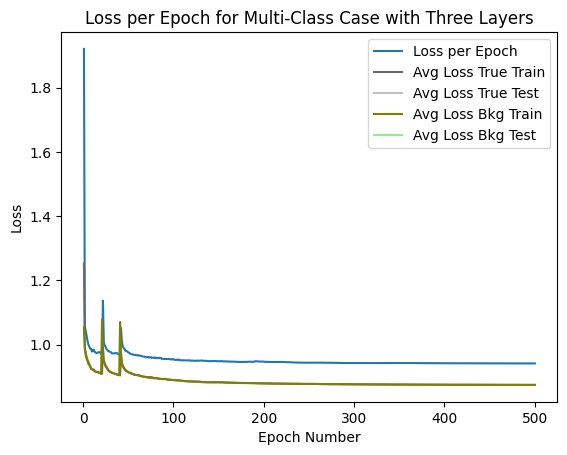

In [49]:
plt.plot(epoch_number, loss_per_epoch, label='Loss per Epoch')
plt.plot(epoch_number, avg_loss_training_true_class,
         'dimgray', label='Avg Loss True Train')
plt.plot(epoch_number, avg_loss_testing_true_class,
         'silver', label='Avg Loss True Test')
plt.plot(epoch_number, avg_loss_training_bkg_classes,
         'olive', label='Avg Loss Bkg Train')
plt.plot(epoch_number, avg_loss_testing_bkg_classes,
         'lightgreen', label='Avg Loss Bkg Test')
plt.xlabel("Epoch Number")
plt.ylabel("Loss")
# plt.yscale("log")
plt.title("Loss per Epoch for Multi-Class Case with Three Layers")
plt.legend()
plt.show()

In [50]:
def plotROCCurve(epoch_scores, epoch_truth_labels, epoch_number):
    # Generate binary labels where 1 represents the true class (class 1), and 0 represents all background classes (0, 2, 3, 4)
    binary_labels = (epoch_truth_labels == 1).astype(int)

    # Extract scores for the true class (first column in `epoch_scores`, class 1)
    true_class_scores = epoch_scores[:, 0]

    # Calculate the ROC curve and AUC
    fpr, tpr, _ = roc_curve(binary_labels, true_class_scores)
    roc_auc = auc(fpr, tpr)

    # Plotting the ROC curve
    plt.plot(fpr, tpr, color='darkorange',
             label='ROC curve (area = %0.3f)' % roc_auc)
    plt.legend(loc="lower right")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for Epoch " + str(epoch_number))
    plt.show()

In [51]:
# Epoch numbers for plot labels
epoch_number = list(range(1, len(loss_per_epoch) + 1))

# Define custom class labels with the new mapping
class_labels = ["Lone-Lone", "True Cluster",
                "Cluster-Lone", "Lone-Cluster", "Cluster-Cluster"]
class_order = [0, 1, 2, 3, 4]

# Function to plot ROC curve for multiclass classification with custom labels


def plotROCCurveMulticlass(epoch_scores, epoch_truth_labels, epoch_number, num_classes=5):
    plt.figure()

    # Iterate over each class in the custom order and compute the ROC curve
    for plot_idx, class_index in enumerate(class_order):
        # Convert truth labels to one-vs-all format (1 for current class, 0 for all others)
        binary_truth_labels = (epoch_truth_labels == class_index).astype(int)

        # Get the predicted probabilities/scores for the current class
        # scores for the current class
        class_scores = epoch_scores[:, class_index]

        # Compute the ROC curve
        fpr, tpr, _ = roc_curve(binary_truth_labels, class_scores)
        roc_auc = auc(fpr, tpr)

        # Plot the ROC curve for the current class with a custom label
        plt.plot(
            fpr, tpr, label=f'{class_labels[plot_idx]} (AUC = {roc_auc:.3f})')

    plt.legend(loc="lower right")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curves for Epoch {epoch_number}")
    plt.show()

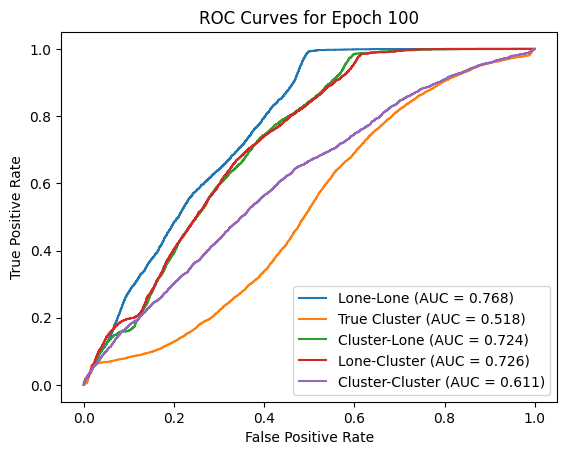

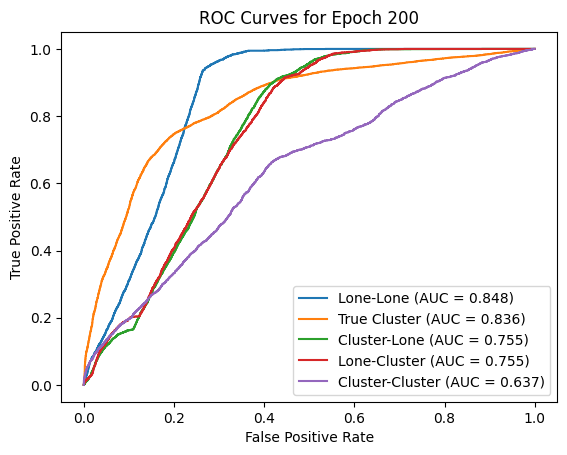

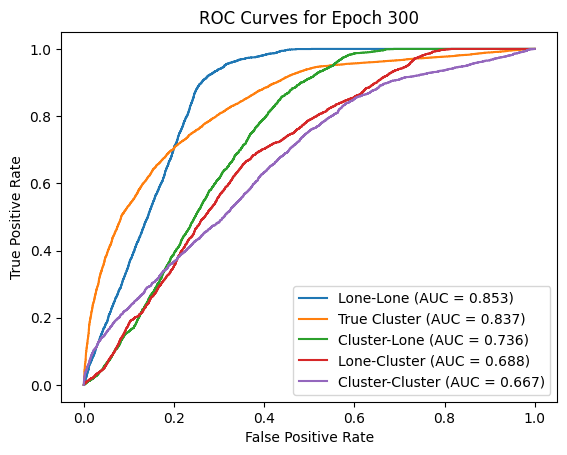

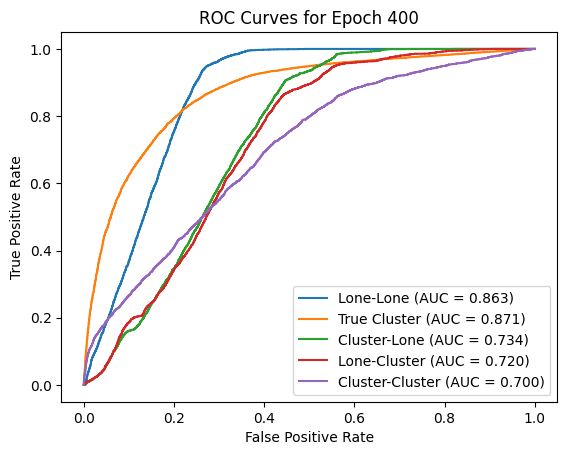

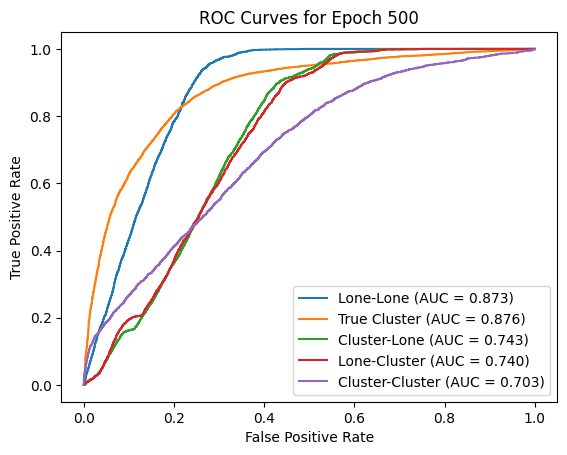

In [52]:
# Total number of epochs
epochNum = 1000
intervalShowingROCGraph = epochNum // 10  # every 100 epochs

# Plot ROC curves at specific intervals with custom labels
for i in range(0, epochNum//2):
    if (i+1) % intervalShowingROCGraph == 0:
        plotROCCurveMulticlass(scores[i], truth_labels[i], i+1)

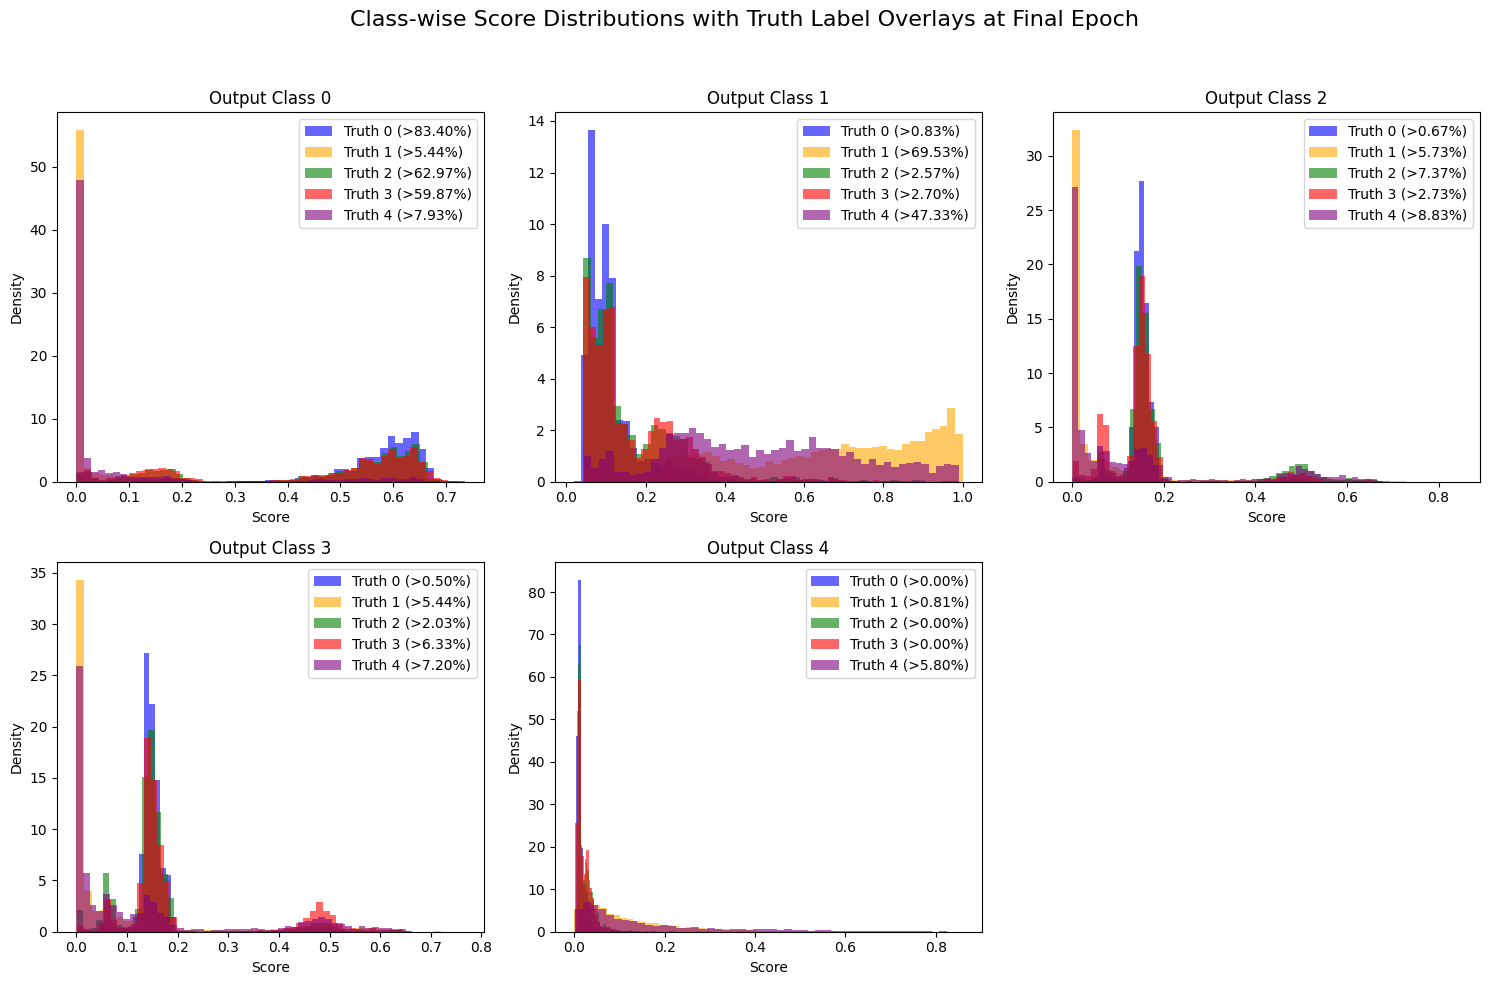

In [53]:
colors = ['Blue', 'Orange', 'Green', 'Red', 'Purple']

# We consider only the last epoch
epoch_index = -1  # Last epoch

# Extract scores and truth labels
epoch_scores = scores[epoch_index]  # Shape: (24000, 5)
epoch_truth_labels = truth_labels[epoch_index]  # Shape: (24000,)

# Create plots
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
axes = axes.flatten()

# Add a global title for the entire figure
fig.suptitle(
    "Class-wise Score Distributions with Truth Label Overlays at Final Epoch", fontsize=16)

for class_idx in range(output_dim):
    ax = axes[class_idx]
    ax.set_title(f'Output Class {class_idx}')
    ax.set_xlabel('Score')
    ax.set_ylabel('Density')

    for truth_type in sorted(np.unique(epoch_truth_labels)):
        # Get scores for the current truth type
        scores_for_truth_type = epoch_scores[epoch_truth_labels ==
                                             truth_type, class_idx]

        # Calculate the fraction of samples with scores > 0.5
        fraction_above_0_5 = np.mean(scores_for_truth_type > 0.5)

        # Plot normalized histogram
        ax.hist(
            scores_for_truth_type,
            bins=50,
            density=True,  # Normalize the histogram
            alpha=0.6,
            label=f'Truth {truth_type} (>{fraction_above_0_5:.2%})',
            color=colors[truth_type % len(colors)]
        )

    ax.legend()

# Hide the third column in the second row if output_dim < rows * cols
if len(axes) > output_dim:
    fig.delaxes(axes[-1])

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title
plt.show()

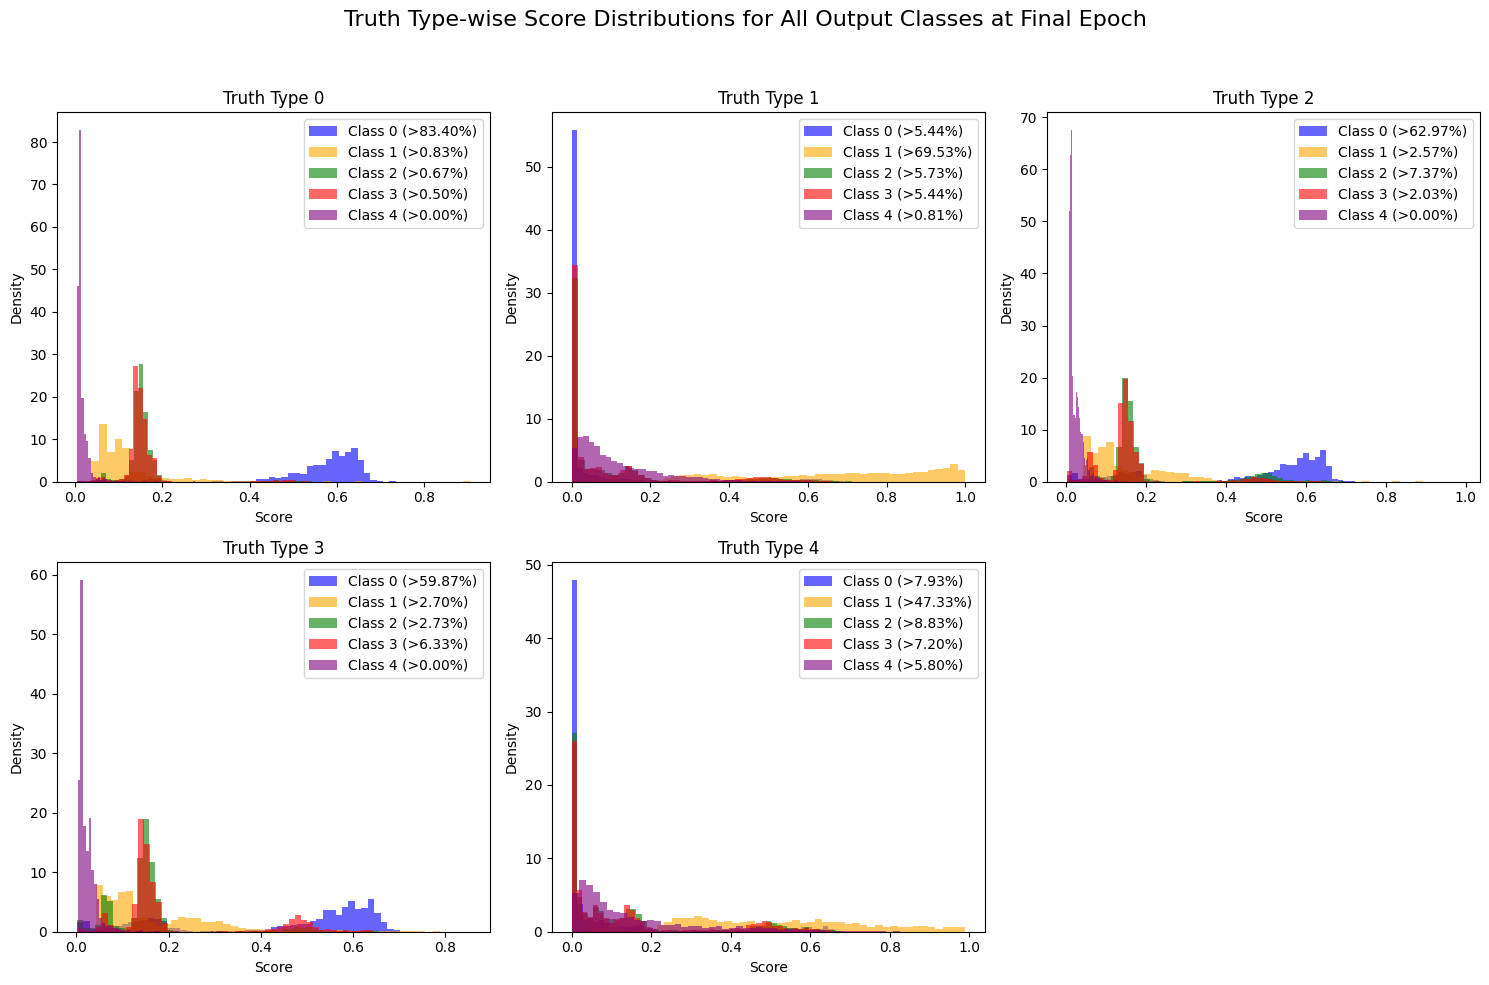

In [54]:
# Unique output classes (5 in total)
output_classes = np.arange(5)  # Classes 0, 1, 2, 3, 4

# Create plots (one for each truth type)
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
axes = axes.flatten()

unique_truth_types = sorted(np.unique(truth_labels))

# Add a global title for the entire figure
fig.suptitle(
    "Truth Type-wise Score Distributions for All Output Classes at Final Epoch", fontsize=16)

# Handle cases where only one truth type is present
if len(unique_truth_types) == 1:
    axes = [axes]

for truth_type_idx, truth_type in enumerate(unique_truth_types):
    ax = axes[truth_type_idx]
    ax.set_title(f'Truth Type {truth_type}')
    ax.set_xlabel('Score')
    ax.set_ylabel('Density')

    for class_idx in output_classes:
        # Get scores for the current output class and the current truth type
        scores_for_truth_type_class = epoch_scores[epoch_truth_labels ==
                                                   truth_type, class_idx]

        # Calculate the fraction of scores > 0.5
        fraction_above_0_5 = np.mean(scores_for_truth_type_class > 0.5)

        # Plot normalized histogram for the current output class
        ax.hist(
            scores_for_truth_type_class,
            bins=50,
            density=True,  # Normalize the histogram
            alpha=0.6,
            label=f'Class {class_idx} (>{fraction_above_0_5:.2%})',
            color=colors[class_idx % len(colors)]
        )

    # Add legend with updated labels
    ax.legend()

# Remove unused subplots
for idx in range(len(unique_truth_types), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title
plt.show()